# How to be a World Class Professor

## Introduction

Picking a professor is fundamental part of the college experience. If you pick the wrong professor, you could be in for a frustrating and long semester. If you pick the right professor, you'll be happy and learning the most you possibly could, regardless of how you do in the class. 

Being a professor can also difficult. Not only does a professor require expert knowledge of the subject matter, it requires that the professor foster a good environment for learning. Creating this requirement takes a lot of skill and experience, and some professors excel at this more than others. Most professors have some desire to see their students succeed (or else why did they become a teacher?), but reaching their students in a way that engages them and enables growth takes a special professor. 

A professor that is new to teaching might wonder what characteristics (from the student's perspective) make a good professor. While their is no secret formula (at least, not one I'm aware of), the popular website "RateMyProfessor.com" has captured a lot of data over the years. Analysis of a small sample of professors from the website will help to answer that question. 


### Import Packages and Load Data

In [1]:
# Import needed packages
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from scipy.stats import t
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from tsdst.modeling import vif, crossVal
from tsdst.feature_selection import getHighCorrs, dropHighCorrs
from tsdst.tmath import rank


# Load the Data
rmp = pd.read_csv('Rateprof.csv', index_col=0)

### Data Investigation and Scrubbing

In [2]:
# Check for NA's in each feature
rmp.isnull().sum(axis=0)

gender             0
numYears           0
numRaters          0
numCourses         0
pepper             0
discipline         0
dept               0
quality            0
helpfulness        0
clarity            0
easiness           0
raterInterest      0
sdQuality          0
sdHelpfulness      0
sdClarity          0
sdEasiness         0
sdRaterInterest    0
dtype: int64

In [3]:
# Define X and Y, in this case, quality is the target
Y = rmp['quality']
X = rmp.drop('quality', axis=1)

In [4]:
# Check categorical columns for unique values and cleanliness
# amoung the categories
cat_cols = [col for col in X.columns if X[col].dtypes == 'object']
for col in cat_cols:
    print(col, ': ', sorted(X[col].unique()))

gender :  ['female', 'male']
pepper :  ['no', 'yes']
discipline :  ['Hum', 'Pre-prof', 'STEM', 'SocSci']
dept :  ['Accounting', 'Anthropology', 'Art', 'Art History', 'Art and design', 'Astronomy/Physics', 'Biology', 'Business', 'Chemistry', 'Communication', 'Communication Disorders', 'Computer Science', 'Criminal Justice', 'Curriculum and Instruction', 'Dance', 'Economics', 'English', 'Environmental Public Health', 'FLTR', 'Finance', 'French', 'Geography', 'Geology', 'German', 'History', 'Information Systems', 'Japanese', 'Kins', 'Library Science', 'Management', 'Managerial Science', 'Marketing', 'Math', 'Music', 'Nursing', 'Philosophy', 'Physics', 'Physics & Astronomy', 'Physics and Astronomy', 'Political Science', 'Psychology', 'Religious Studies', 'Social Work', 'Sociology', 'Spanish', 'Special Education', 'Theater', 'Womens Studies']


In [5]:
# Clean up dept column for obvious duplicates
new_phys_lab = 'Physics and Astronomy'
old_phys_labs = ['Physics', 'Physics & Astronomy', 'Astronomy/Physics']

for phys_col in old_phys_labs:
    X.loc[X['dept'] == phys_col, 'dept'] = new_phys_lab

## Part I: Do Difficult Courses get Higher Ratings?

One aspect of a professor's quality we might want to understand is how the course difficulty (or rather, the perceived course difficulty) affects a professor's quality. Looking at the correlation between the variables `quality` and `easiness`, we can see that there is a fairly strong association between easiness and teacher quality. This not unexpected, as we would expect that when a class is easier, the student's overall impression of the course improves. It is interesting to note, however, that easiness is not the strongest association. So even though easiness of the course does influence a student to give a higher rating, we can infer that course easiness is not the most important aspect of receiving a high rating from a student. 

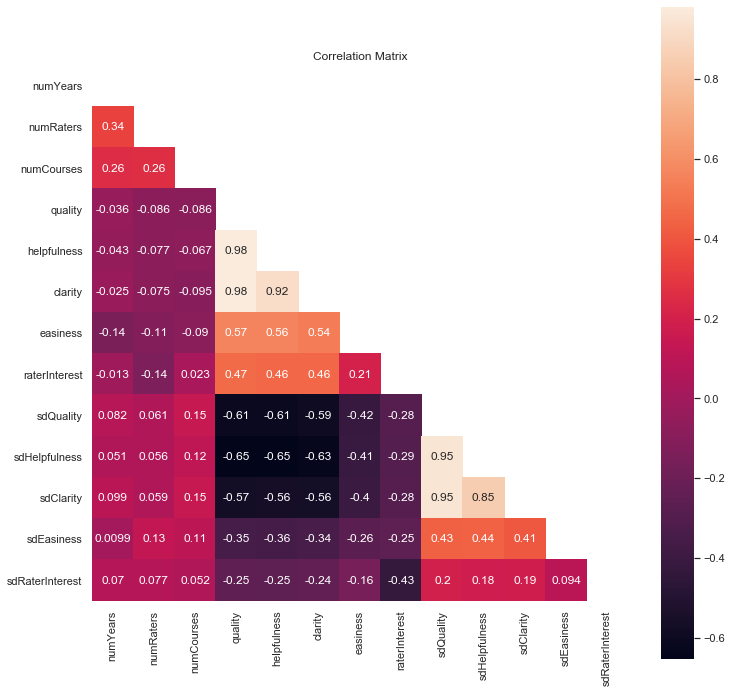

In [6]:
# Create correlation plot for numerical variables
corr = rmp.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.set(rc={'figure.figsize':(12, 12)})
with sns.axes_style("white"):
    sns.heatmap(rmp.corr(), annot=True, square=True, mask=mask)
    plt.title("Correlation Matrix")

## Part II: Can Gender or Attractiveness Bias a Professor's Ratings?

Bias exists almost everywhere, intentional or not, so are there biases unrelated to teaching ability that influence a student's quality rating? One way to answer this is to look at the average quality rating for males and females, as well as attractive or not attractive professors. To examine this, we will partition the data into three groups: One containing all of the data, and the other two containing professors who scored in the top and bottom 25% of the quality category. We will look at the top and bottom 25% of quality ratings because we might expect there to be differences between high and low quality professors.  

In [7]:
# Standard Error of the Mean calculation
ci_stand_error = lambda x: (x.std(ddof=1)/(np.sqrt(x.shape[0])))*t.ppf(0.975, df=x.shape[0])

def group_differences(target_val, group_val):
    '''
    Groups the target variable by a grouping variable, and returns the mean values
    and error for each group. Checks the complete dataset, as well as the top and
    bottom 25% of the target values.
    
    target_val : str
        The target column of the dataset
    group_val : str
        The column to create the groups for comparison
    '''
    cutoffs = np.percentile(rmp[target_val].values, [25, 75])
    overall = rmp.groupby([group_val], as_index=True).agg(
                          {target_val: ['mean', ci_stand_error]})
    overall.columns.set_levels([['Overall'], ['Mean', 'Error']],
                                  level=None, inplace=True)
    top_25 = rmp[rmp[target_val] > cutoffs[1]].groupby([group_val], as_index=True).agg(
                          {target_val:['mean', ci_stand_error]})
    top_25.columns.set_levels([['Top 25%'], ['Mean', 'Error']],
                                  level=None, inplace=True)
    low_25 = rmp[rmp[target_val] < cutoffs[0]].groupby([group_val], as_index=True).agg(
                          {target_val:['mean', ci_stand_error]})
    low_25.columns.set_levels([['Bottom 25%'], ['Mean', 'Error']],
                                  level=None, inplace=True)
    grouped_df = pd.concat((overall, top_25, low_25), axis=1)
    return grouped_df


gender_df = group_differences(target_val='quality', group_val='gender')

In [8]:
gender_df

Overall             Top 25%           Bottom 25%          
            Mean     Error      Mean     Error       Mean     Error
gender                                                             
female  3.531646  0.134226  4.622103  0.063153   2.363907  0.127140
male    3.608404  0.112739  4.575655  0.059230   2.496558  0.104288

In [9]:
# Extract the error values to place in the bar plot
err_vals = gender_df.T.xs('Error', level=1, drop_level=False).T.values

([<matplotlib.axis.XTick at 0x15003a5d048>,
 <a list of 3 Text xticklabel objects>)

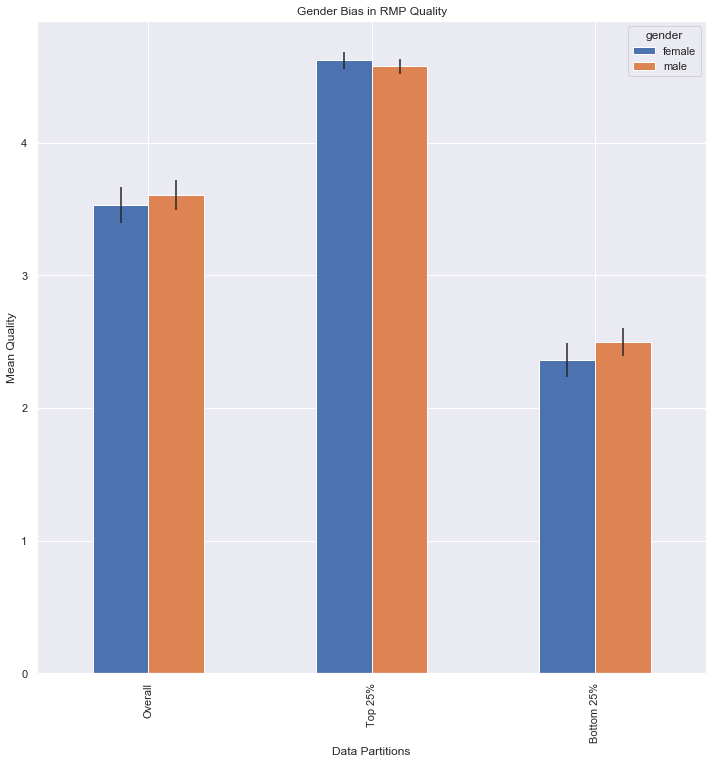

In [10]:
gender_df.T.xs('Mean', level=1, drop_level=False).plot.bar(yerr=err_vals,
                                                           title='Gender Bias in RMP Quality',
                                                           xlabel='Data Partitions',
                                                           ylabel='Mean Quality')
plt.xticks(ticks=[0, 1, 2], labels=['Overall', 'Top 25%', 'Bottom 25%'])

From the above figure, it appears that there is not much gender bias in professor quality ratings. Based on this data, both genders receive equal quality ratings on average. It is interesting to note that in the top 25%, male professors have a slightly higher mean quality rating, and in the bottom 25%, females have a slightly higher mean quality rating. However, based on the standard error, these differences are likely attributed to randomness.

Let's see if the same can be said about attractiveness.

In [11]:
# Create group differences table for attractiveness (pepper)
pepper_df = group_differences(target_val='quality', group_val='pepper')
pepper_df

Overall             Top 25%           Bottom 25%          
         Mean     Error      Mean     Error       Mean     Error
no   3.456289  0.089932  4.589306  0.057045   2.438884  0.080443
yes  4.401279  0.115343  4.604155  0.067119        NaN       NaN

In [12]:
# Fill in the missing values for plotting and extract error values
pepper_df = pepper_df.fillna(0)
err_vals = pepper_df.T.xs('Error', level=1, drop_level=False).T.values

([<matplotlib.axis.XTick at 0x15003af2bc8>,
 <a list of 3 Text xticklabel objects>)

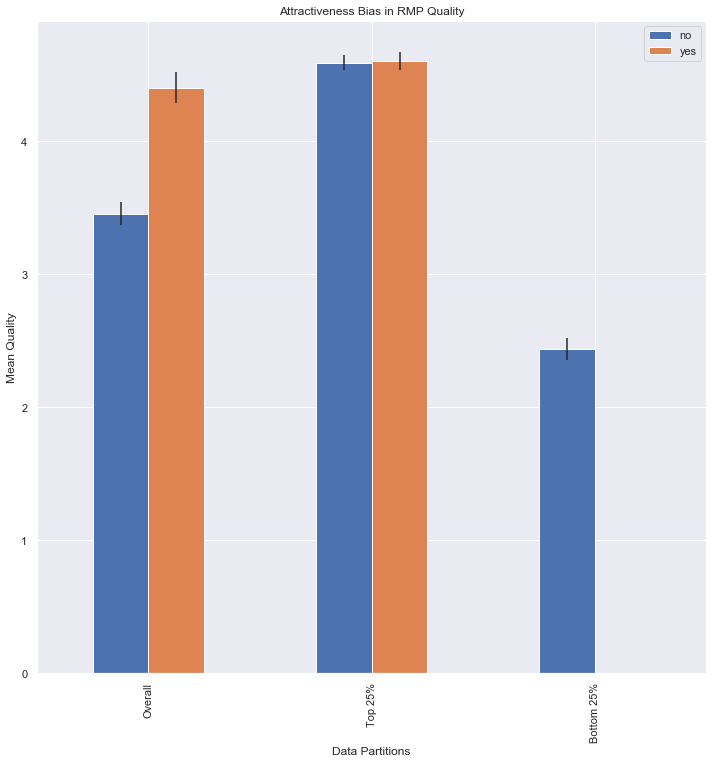

In [13]:
pepper_df.T.xs('Mean', level=1, drop_level=False).plot.bar(yerr=err_vals,
                                                           title='Attractiveness Bias in RMP Quality',
                                                           xlabel='Data Partitions',
                                                           ylabel='Mean Quality')
plt.xticks(ticks=[0, 1, 2], labels=['Overall', 'Top 25%', 'Bottom 25%'])

Attractiveness, on the other hand, seems to highly influence a student's quality rating for a professor. In the bottom 25% of quality ratings, there wasn't a single attractive professor. This is very different from the top 25% of quality ratings, where attractive and non-attractive professors score evenly. It seems unlikely that unattractive teachers are inherently bad, so what this could suggest is that when students have a high quality teacher, they give a more objective attractiveness rating to their teacher, whereas students are unwilling to admit that a low quality teacher is attractive because the students are unsatisfied with the class. Or, it might also suggest that a high quality teacher appears more attractive to a student because they have a positive experience with the class. Either way, there is clearly a bias in quality ratings based on professor attractiveness.

### Part III: What Attributes Make a Good Professor?

To answer this question, we will build a linear model that predicts a professors quality rating based on the other available attributes.

In [14]:
# Binary Encode categorical columns. Because we're using Linear Regression later,
# drop the first variable
X_dum = pd.get_dummies(X, columns=cat_cols, drop_first=True)

In [15]:
# Check the determinant for a low value, which would indicate 
# an improper linear model
np.linalg.det(X_dum.corr())

1.0289871424439426e-49

In [16]:
# Check High correlations for potential bad actors causing singular correlation 
# matrix
getHighCorrs(X_dum.corr(), corr_thres=0.9)

{'helpfulness..&..clarity': 0.9208069804849518,
 'sdQuality..&..sdHelpfulness': 0.9540072575707406,
 'sdQuality..&..sdClarity': 0.9526856874919287}

In [17]:
# It appears sdQuality is highly correlated with sdHelpfulness and 
# sdClarity. Since the correlation is high with two variables, and 
# since the sdQuality is a measure of the target (so it probably
# should be romved anyway to avoid any truth leakage), we 
# will remove sdQuality
X_dum_drop = X_dum.drop("sdQuality", axis=1)

In [18]:
# Check determinant again
np.linalg.det(X_dum_drop.corr())

7.002201639311429e-48

In [19]:
# Check the proportion of discipline categories against department categories
# to check for a hierachal structure
X[['discipline','dept', 'gender']].groupby(['discipline','dept']).count()

gender
discipline dept                               
Hum        Art                               5
           Art History                       1
           Art and design                    1
           Dance                             1
           English                          49
           FLTR                              1
           French                            4
           German                            4
           History                          17
           Japanese                          1
           Music                             9
           Philosophy                        7
           Religious Studies                 8
           Spanish                          20
           Theater                           3
           Womens Studies                    3
Pre-prof   Accounting                        8
           Business                          9
           Criminal Justice                  1
           Curriculum and Instruction        1
           Economics                        13
           Environmental Public Health       1
           Finance                           3
           Information Systems               2
           Kins                             10
           Library Science                   1
           Management                        2
           Managerial Science                2
           Marketing                         4
           Nursing                           1
           Social Work                       3
           Special Education                 2
STEM       Biology                          20
           Chemistry                        20
           Computer Science                  5
           Geology                          12
           Math                             34
           Physics and Astronomy            12
SocSci     Anthropology                      5
           Communication                    18
           Communication Disorders           2
           Geography                         3
           Political Science                 8
           Psychology                       20
           Sociology                        10

In [20]:
# Since discipline and dept are hierarchal, and thus collinear, we will
# remove dept to promote parsimony
dept_cols = [col for col in X_dum_drop.columns if 'dept' in col]
X_dum_drop_nodept = X_dum_drop.drop(dept_cols, axis=1)

In [21]:
X_dum_drop_nodept

,numYears,numRaters,numCourses,helpfulness,clarity,easiness,raterInterest,sdHelpfulness,sdClarity,sdEasiness,sdRaterInterest,gender_male,pepper_yes,discipline_Pre-prof,discipline_STEM,discipline_SocSci
1,7,11,5,4.636364,4.636364,4.818182,3.545455,0.674200,0.504525,0.404520,1.128152,1,0,0,0,0
2,6,11,5,4.545455,4.090909,4.363636,4.000000,0.934199,0.943880,0.504525,1.074436,1,0,0,0,0
3,10,43,2,4.720930,4.860465,4.604651,3.432432,0.666390,0.412968,0.540702,1.236944,1,0,0,0,0
4,11,24,5,4.458333,4.041667,2.791667,3.181818,0.931533,0.999094,0.588230,1.332251,1,0,0,0,0
5,11,19,7,4.684211,4.684211,4.473684,4.214286,0.820070,0.582393,0.611775,0.974961,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362,5,21,3,2.714286,2.523810,3.619048,3.411765,1.553797,1.691717,1.430950,1.003670,0,0,1,0,0
363,4,15,2,3.066667,2.866667,2.666667,2.533333,1.334523,1.355764,1.447494,1.125463,0,0,1,0,0
364,2,10,3,3.200000,3.300000,3.000000,2.700000,1.475730,1.059350,1.563472,0.948683,0,0,1,0,0
365,9,11,5,1.909091,1.909091,2.272727,2.545455,1.578261,1.300350,1.618080,1.634848,0,0,1,0,0


In [22]:
# Check Corr determinant
np.linalg.det(X_dum_drop_nodept.corr())

0.001981231490314251

In [23]:
# Check vif
vif(X_dum_drop_nodept)

,Variance Inflation Factors
numYears,1.291571
numRaters,1.311203
numCourses,1.253988
helpfulness,7.983586
clarity,7.052353
easiness,1.670961
raterInterest,1.691271
sdHelpfulness,4.569541
sdClarity,3.972736
sdEasiness,1.326338


In [24]:
# Creating multiple versions of the dataset to compare performance
# split into train/test
np.random.seed(1)
test_size = 0.2
test_samples = int(X.shape[0]*0.2)
indx = np.random.choice(np.arange(0, X.shape[0]), X.shape[0])

y_test = Y.iloc[indx[:test_samples]]
y_train = Y.iloc[indx[test_samples:]]

X_test_dum = X_dum.iloc[indx[:test_samples], :]
X_test_dum_drop = X_dum_drop.iloc[indx[:test_samples]]
X_test_dum_drop_nodept = X_dum_drop_nodept.iloc[indx[:test_samples]]

X_train_dum = X_dum.iloc[indx[test_samples:], :]
X_train_dum_drop = X_dum_drop.iloc[indx[test_samples:]]
X_train_dum_drop_nodept = X_dum_drop_nodept.iloc[indx[test_samples:]]

In [25]:
mod = LinearRegression(normalize=False)

#### Final Model

In [26]:
# Model Cross-validation
cv = crossVal(X_train_dum_drop_nodept, y_train, cv_iterations=5, model=mod,
              mtype='regression', metrics=['R2', 'Adj. R2', 'Bias', 'RPMSE'],
              random_state=1)

Out of Sample: 
	R2     : μ: 0.9938, σ: 0.0106, 2σ Interval (0.9727, 1.0149)
	Adj. R2: μ: 0.9914, σ: 0.0147, 2σ Interval (0.9620, 1.0207)
	Bias   : μ: 0.0013, σ: 0.0086, 2σ Interval (-0.0158, 0.0184)
	RPMSE  : μ: 0.0472, σ: 0.0366, 2σ Interval (-0.0261, 0.1204)



In [27]:
# Standardize Data for Coefficient Ranking
trans = StandardScaler().fit(X_train_dum_drop_nodept)
stand_mod = mod.fit(trans.transform(X_train_dum_drop_nodept), y_train)
stand_mod.score(trans.transform(X_test_dum_drop_nodept), y_test)

0.999364598623143

In [28]:
coef_df = pd.DataFrame(stand_mod.coef_,
                       index=X_train_dum_drop_nodept.columns,
                       columns=['Coefficients'])
coef_df['Rank'] = rank(np.abs(stand_mod.coef_))
coef_df.sort_values('Rank', ascending=True)

,Coefficients,Rank
helpfulness,0.438174,1
clarity,0.383360,2
easiness,0.007510,3
numCourses,-0.007386,4
numRaters,-0.007242,5
sdEasiness,0.005994,6
sdClarity,0.005554,7
numYears,0.002687,8
gender_male,0.002468,9
discipline_STEM,0.002449,10


Text(0.5, 1.0, 'Linear Model Coefficient Values')

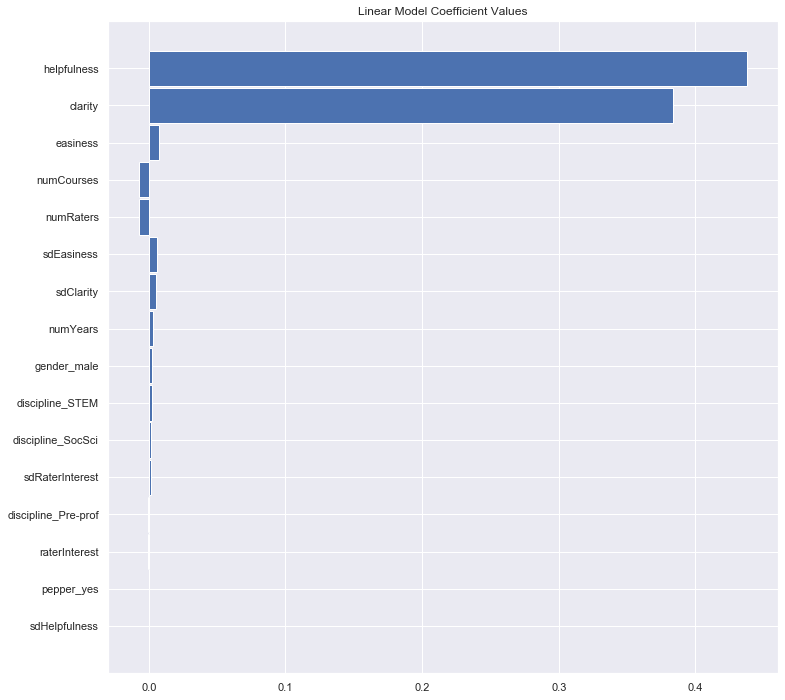

In [29]:
sorted_df = coef_df.sort_values('Rank', ascending=False)
plt.barh(y=sorted_df.index, width=sorted_df['Coefficients'].values, height=0.95)
plt.title("Linear Model Coefficient Values")

By plotting the coefficients from the linear regression model, it appears that helpfulness and clarity are the two most important factors in determining a professors quality rating. Both new and current professors should focus on being helpful and teaching clearly if they want to improve their ratings.

### Conclusion

A professor can learn a lot from their students, and with data from RateMyProfessors.com, a professor can learn what attributes will improve their teaching. While students may be biased in their opinions based on a professors' attractiveness or how well they are doing in the course, the two main attributes that stand out clearly are being helpful and being clear. If a professor can master both of those areas, they should be able to expect a high quality rating from their students. 

This data was analyzed using only a small sample. With a larger sample of professor ratings, these conclusions could be different, and further study is recommended.

#### Other Models Explored

In [30]:
crossVal(X_train_dum, y_train, cv_iterations=5, model=mod,
         mtype='regression', metrics=['R2', 'Bias', 'RPMSE'])

Out of Sample: 
	R2   : μ: 0.9949, σ: 0.0058, 2σ Interval (0.9833, 1.0065)
	Bias : μ: -0.0010, σ: 0.0117, 2σ Interval (-0.0244, 0.0223)
	RPMSE: μ: 0.0531, σ: 0.0337, 2σ Interval (-0.0143, 0.1204)



{'Out of Sample': {'R2': [0.9845994066386171,
   0.997960679211696,
   0.9981374148139766,
   0.9969558660629513,
   0.9968286341760101],
  'Bias': [0.014525911312351808,
   -0.0024958444396919873,
   -0.0058956114340192635,
   0.0051247863793476645,
   -0.016495093885178367],
  'RPMSE': [0.1122133701310268,
   0.02906317433787487,
   0.03585613195181711,
   0.045783577647179746,
   0.04251341738729825]}}

In [31]:
mod.fit(X_train_dum, y_train).score(X_test_dum, y_test)

0.9989566806388664

In [32]:
crossVal(X_train_dum_drop, y_train, cv_iterations=5, model=mod,
         mtype='regression', metrics=['R2', 'Bias', 'RPMSE'])

Out of Sample: 
	R2   : μ: 0.9950, σ: 0.0052, 2σ Interval (0.9845, 1.0054)
	Bias : μ: -0.0003, σ: 0.0084, 2σ Interval (-0.0171, 0.0166)
	RPMSE: μ: 0.0533, σ: 0.0340, 2σ Interval (-0.0147, 0.1213)



{'Out of Sample': {'R2': [0.9957935793826507,
   0.9982149887233284,
   0.9976996576200208,
   0.9857809352218987,
   0.9973766789657643],
  'Bias': [-0.0017837066074156975,
   -0.00484913202624634,
   -0.004324906436085296,
   0.014659743230803986,
   -0.005007003159663224],
  'RPMSE': [0.044229042691545574,
   0.03145912791791415,
   0.03949072523653649,
   0.11358566977551166,
   0.03788271212303237]}}

In [33]:
mod.fit(X_train_dum_drop, y_train).score(X_test_dum_drop, y_test)

0.9990278325750064

In [34]:
crossVal(X_train_dum, y_train, cv_iterations=5, model=Ridge(alpha=0.001),
         mtype='regression', metrics=['R2', 'Bias', 'RPMSE'])

Out of Sample: 
	R2   : μ: 0.9933, σ: 0.0100, 2σ Interval (0.9733, 1.0133)
	Bias : μ: 0.0001, σ: 0.0104, 2σ Interval (-0.0207, 0.0210)
	RPMSE: μ: 0.0532, σ: 0.0344, 2σ Interval (-0.0157, 0.1220)



{'Out of Sample': {'R2': [0.9983369893283355,
   0.9982835780697875,
   0.9974016269022554,
   0.9754256716201636,
   0.997140476667337],
  'Bias': [0.0004575101586454122,
   0.0019155147041557239,
   -0.006480369596974675,
   0.016136680004946342,
   -0.011361354628363747],
  'RPMSE': [0.03152163848619399,
   0.0335763313284476,
   0.04559092115098044,
   0.1138635948077128,
   0.041227759530573345]}}

In [35]:
Ridge(alpha=0.001).fit(X_train_dum, y_train).score(X_test_dum, y_test)

0.9989573968233914

In [36]:
crossVal(X_train_dum, y_train, cv_iterations=5, model=Lasso(alpha=0.00001),
         mtype='regression', metrics=['R2', 'Bias', 'RPMSE'])

Out of Sample: 
	R2   : μ: 0.9941, σ: 0.0084, 2σ Interval (0.9773, 1.0109)
	Bias : μ: -0.0007, σ: 0.0094, 2σ Interval (-0.0195, 0.0181)
	RPMSE: μ: 0.0525, σ: 0.0337, 2σ Interval (-0.0149, 0.1198)



{'Out of Sample': {'R2': [0.998019955581663,
   0.9790744049782417,
   0.9984010022090609,
   0.9976387562207634,
   0.9972167962539535],
  'Bias': [-0.0058523932482859855,
   0.014028008090737195,
   -0.00503279349342849,
   -0.009585024523624067,
   0.0027919360140690836],
  'RPMSE': [0.035057262132702945,
   0.11214111425073885,
   0.03139180864911986,
   0.04044587860220127,
   0.04326486836559891]}}

In [37]:
Lasso(alpha=0.00001).fit(X_train_dum, y_train).score(X_test_dum, y_test)

0.9989907247277899